## 0. Import necessary modules

In [2]:
# Add path to auxiliary custom libraries
import sys
sys.path.insert(0, './functions')

In [3]:
# Data Manipulation
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import pickle

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from f_viz import plot_corr_heatmap, barplot_cstm # Custom functions

In [4]:
# Extend number of Pandas df columns to display
pd.set_option('display.max_columns', 60)

In [5]:
%matplotlib inline

## 1. Load data

In [6]:
# Local paths to data
proc_data_PATH = './processed_data/'

In [7]:
with open(proc_data_PATH + 'dataframes.pkl', 'rb') as f:
    db_20k_fs, db_10k = pickle.load(f)

In [8]:
with open(proc_data_PATH + 'proc_dataframes_no_dummies.pkl', 'rb') as f:
    db_20k_imp_nd,db_10k_imp_nd = pickle.load(f)

## 2. Correlation between pairs of features before and after imputation

We will take a look at the impact the imputation process took on the original correlation values. Given the large amount of missing values and that we imputed them all with constant ones, it is very likely that their original distributions were modified to a certain degree.

In [9]:
# We make sure the same features are shown in the heatmap for both cases
drop_list_cat = ['PhoneType','Province','Right Address',
             'Type of House','Socieconomic Status',
             'Estimated number of cars','Probability of Second Residence']
drop_list_imp = ['Number of Mobile Phones', 'Number of Fixed Lines', 'ADSL', '3G Devices','Birthdate']

db_20k_fs_hm = db_20k_fs.drop(drop_list_cat + drop_list_imp,axis=1)

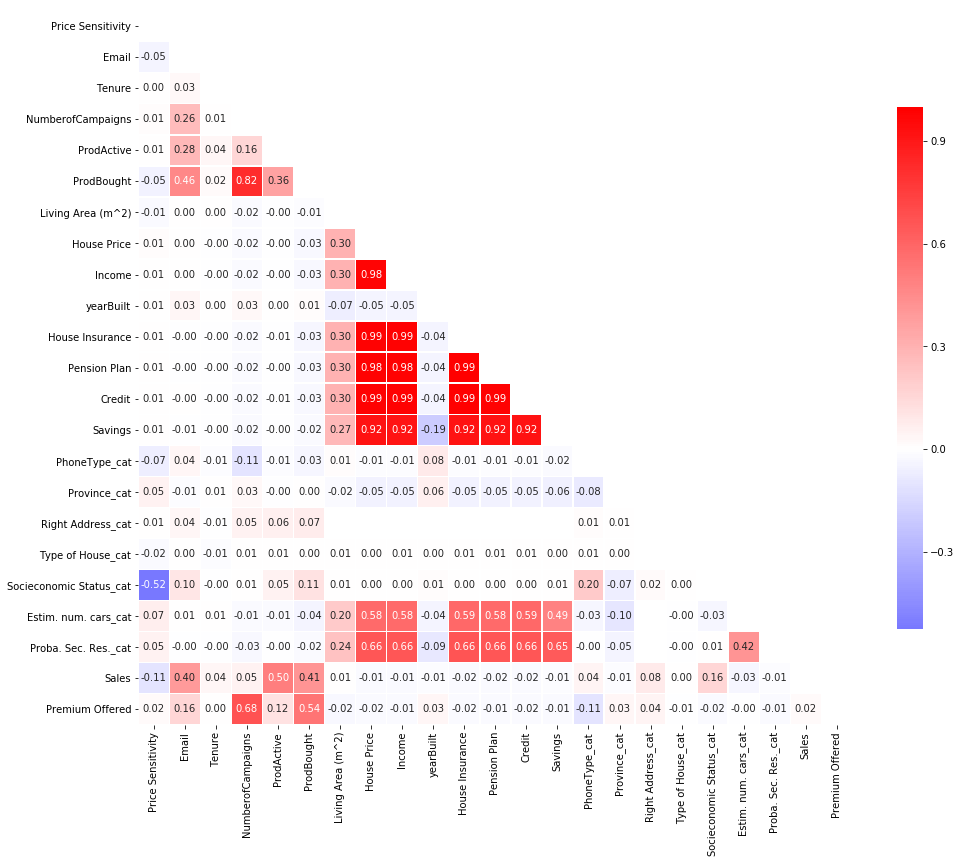

In [10]:
plot_corr_heatmap(db_20k_fs_hm.corr())

In [11]:
# We impose the same order of columns to make comparisons easier
db_20k_imp_nd = db_20k_imp_nd[list(db_20k_fs_hm.columns)]

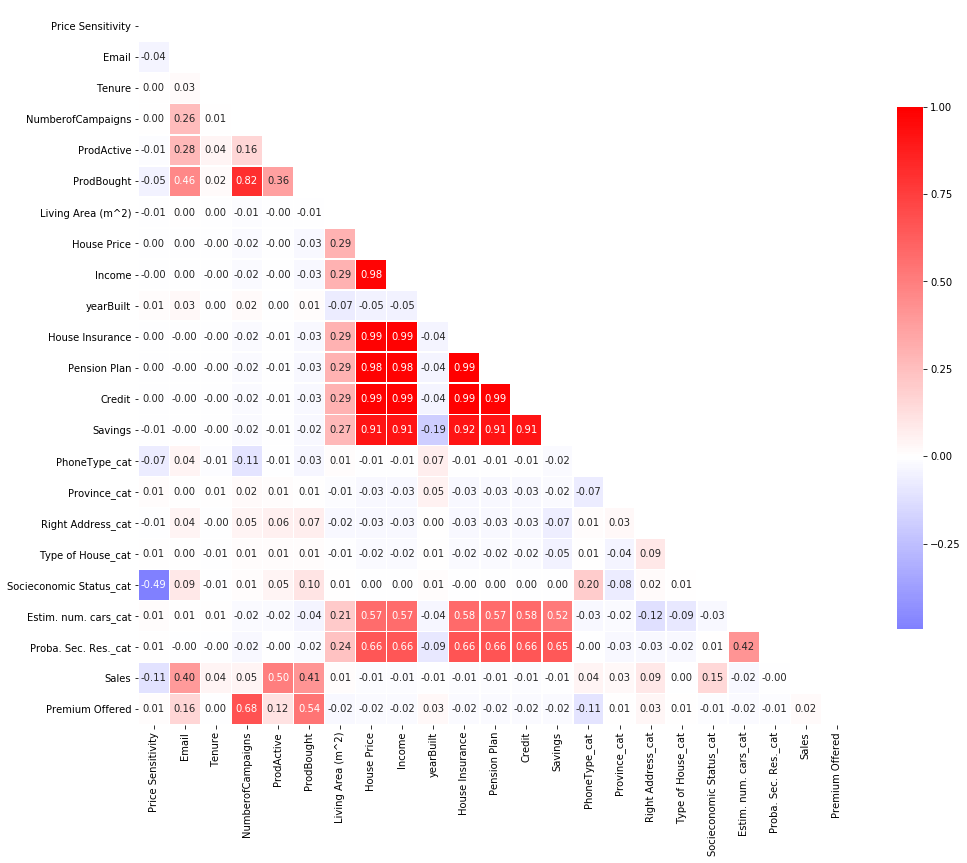

In [12]:
plot_corr_heatmap(db_20k_imp_nd.corr())

In [13]:
# Auxiliary dataframe for creating figure (ppt)
db_corr = db_20k_imp_nd.corr()['Sales'].to_frame()
db_corr['Abs'] = abs(db_corr['Sales'])
db_corr = db_corr.sort_values(by='Abs',ascending=False)
db_corr['Features'] = db_corr.index
db_corr = db_corr.iloc[1:11]
db_corr.head()

,Sales,Abs,Features
ProdActive,0.503119,0.503119,ProdActive
ProdBought,0.413297,0.413297,ProdBought
Email,0.398181,0.398181,Email
Socieconomic Status_cat,0.151842,0.151842,Socieconomic Status_cat
Price Sensitivity,-0.111511,0.111511,Price Sensitivity


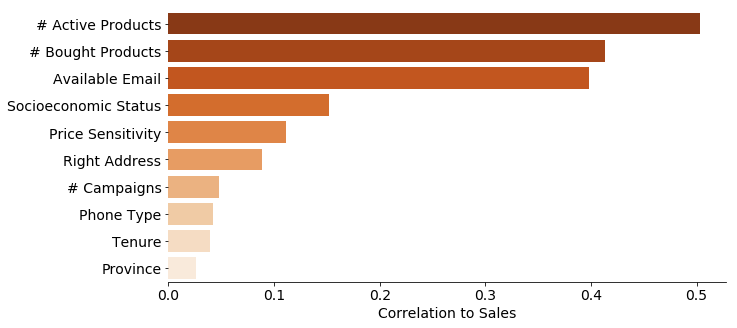

In [14]:
# Figure for ppt
fig, ax = plt.subplots(figsize=(10,5))
sns.barplot(x ='Abs',y='Features',data=db_corr,palette=reversed(sns.color_palette("Oranges", 10)),orient='h',ax=ax)

ax.set_xlabel('Correlation to Sales', fontsize=14)
ax.set_ylabel('', fontsize=14)
ax.xaxis.set_tick_params(labelsize=14)
ax.yaxis.set_tick_params(labelsize=14)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)

ft_labels = ['# Active Products','# Bought Products','Available Email','Socioeconomic Status',
            'Price Sensitivity','Right Address','# Campaigns','Phone Type','Tenure','Province']
_ = plt.yticks(np.arange(len(ft_labels)),ft_labels)

fig.savefig("ft_corr.svg", bbox_inches='tight')

Overall, it looks very similar, but let's take a look at the difference between both correlation matrixes, so we can better estimate the changes.

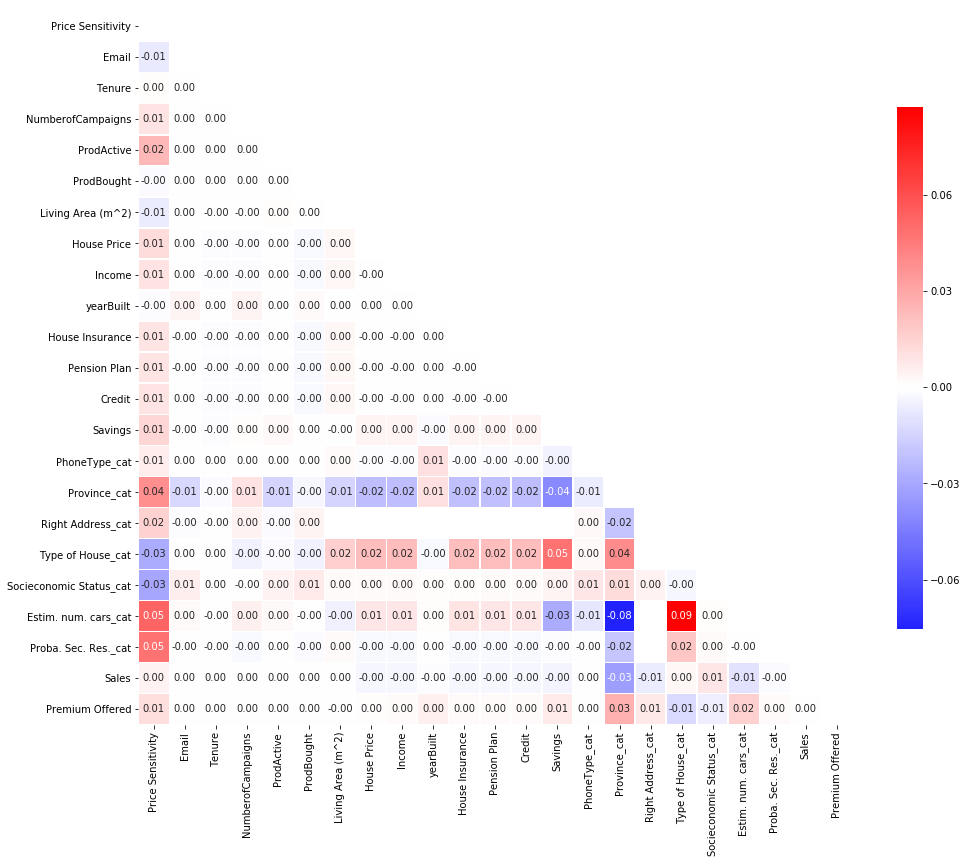

In [14]:
plot_corr_heatmap((db_20k_fs_hm.corr() - db_20k_imp_nd.corr()))

We see most correlation coefficients did not change too much after imputation, which is a good sign this process, meaning that we did not excessively disturbed the original relationship between features.

## 3. Detailed Analysis of Features

We will now delve into the distribution of some particular features and their relationship to our target and optimization variables.

### 3.1 Sales and Premium Offered

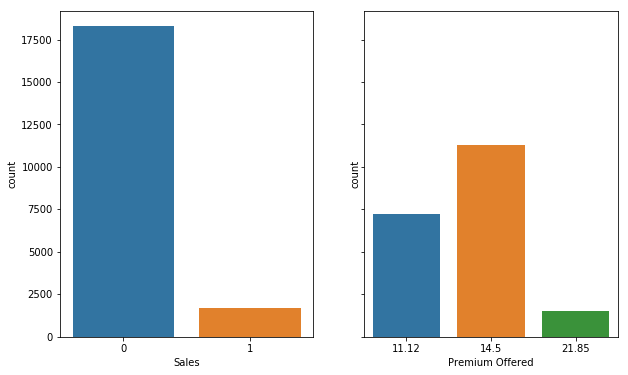

In [15]:
fig, axs = plt.subplots(1, 2, figsize=(10, 6), gridspec_kw = dict(wspace = 0.2), sharey=True)
_ = sns.countplot(x='Sales',data=db_20k_imp_nd, ax=axs[0])
_ = sns.countplot(x='Premium Offered',data=db_20k_imp_nd, ax=axs[1])

Both target variable and optimization one are discrete.

'Sales' has an important class imbalance, being the positive class (clients who contracted the insurance) about 9% of all instances.

'Premium Offered' has three distinct values that probably correspond to three products that have been offered so far by our insurance company to their customers. The most expensive product is offered less frequently than the other two, with the intermediate price one being a bit more common.

[91.425  8.575]


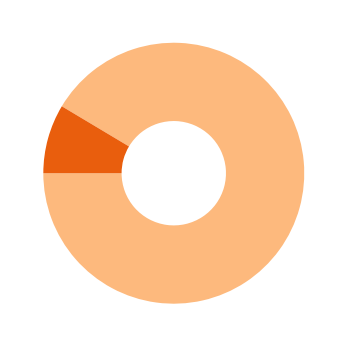

In [16]:
# Figure for ppt
donut_data = [18285, 1715]
print(np.array(donut_data)*100/20000)
donut_data = list(db_20k_imp_nd['Sales'].value_counts())
fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(aspect="equal"))
_ = ax.pie(donut_data, wedgeprops=dict(width=0.6), startangle=180,colors=sns.color_palette("Oranges", 2))    
fig.savefig("donut_sales.svg", bbox_inches='tight')

C:\Users\amartinp\AppData\Local\conda\conda\envs\ml_env\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


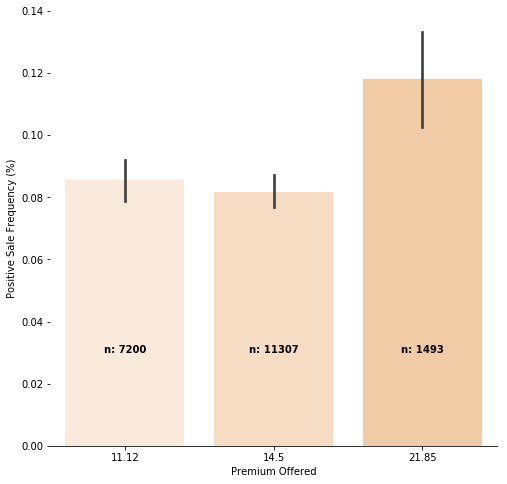

In [17]:
_ = barplot_cstm(x="Premium Offered",y="Sales",data=db_20k_imp_nd,
                 xlabel='Premium Offered',ylabel='Positive Sale Frequency (%)')

In [18]:
# Auxiliary dataframe for creating figure (ppt)
df_count = db_20k_imp_nd.groupby(['Sales','Premium Offered']).count().iloc[:,0].to_frame().unstack('Sales')
df_count.columns = df_count.columns.droplevel()
df_count['Total'] = df_count[0] + df_count[1]
df_count

Sales,0,1,Total
Premium Offered,,,
11.12,6585,615,7200
14.50,10383,924,11307
21.85,1317,176,1493


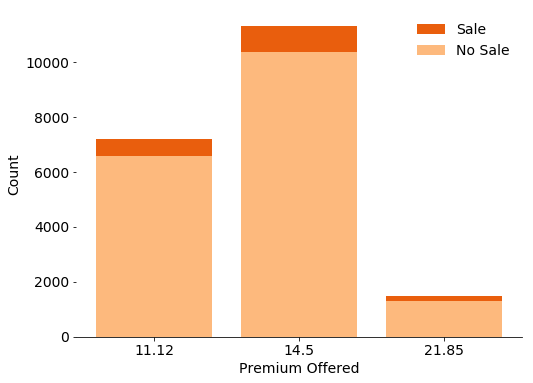

In [19]:
# Figure for ppt
fig, ax = plt.subplots(figsize=(8,6))
ind = np.arange(3)
width = 0.8
p1 = plt.bar(ind, df_count[0], width, color=sns.color_palette("Oranges", 2)[0])
p2 = plt.bar(ind, df_count[1], width, bottom=df_count[0],color=sns.color_palette("Oranges", 2)[-1])

plt.legend((p2[0], p1[0]), ('Sale', 'No Sale'), frameon=False, fontsize=14)

sns.despine(left=True)
plt.ylabel("Count",fontsize=14)
plt.xlabel("Premium Offered",fontsize=14)
plt.xticks(ind, list(df_count.index))
ax.xaxis.set_tick_params(labelsize=14)
ax.yaxis.set_tick_params(labelsize=14)
    
fig.savefig("sale_count_by_prem.svg", bbox_inches='tight')

The overall positive sale frequency is low, and when we segment it by 'Premium Offered', it is still low for all distinct values. Tha means there is not a product that sells much better than the other two, even though the higher premium is slightly over the other two (but this might come from the fact that it is offered to wealthier people).

Let's segment it by Socioeconomic Status and see if there are major differences.

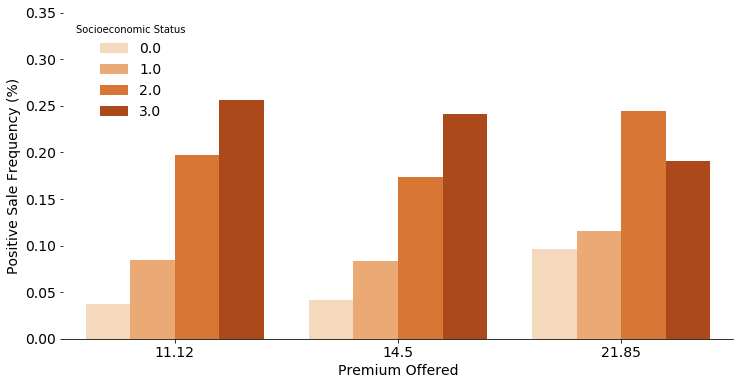

In [20]:
# Figure for ppt
fig, ax = plt.subplots(figsize=(12,6))
sns.barplot(y ='Sales', x='Premium Offered',hue='Socieconomic Status_cat',
                data=db_20k_imp_nd,palette=sns.color_palette("Oranges", 4),ax=ax,ci=None)
ax.set_xlabel('Premium Offered', fontsize=14)
ax.set_ylabel('Positive Sale Frequency (%)', fontsize=14)

ax.xaxis.set_tick_params(labelsize=14)
ax.yaxis.set_tick_params(labelsize=14)
ax.set_ylim(0,0.35)

#xticks(fontsize=14, rotation=90)

ax.legend(title="Socioeconomic Status",frameon=False,fontsize=14)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)


fig.savefig("sale_by_prem_by_status.svg", bbox_inches='tight')

Now some clear patters come to light:
- For all values of 'Premium Offered', it is individuales with higher socioeconomic status who buy more often, which makes sense since they can afford it.

- The most expensive premium sells better across most socioeconomic statuses (all but the highest) than the other two. The reason might be that this modality offers a clearly better coverage than the other to, making it more attractive despite of its higher price.


Let's now break down the relationship between 'Sales' and 'Premium Offered' using some other features that are correlated to them.

C:\Users\amartinp\AppData\Local\conda\conda\envs\ml_env\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


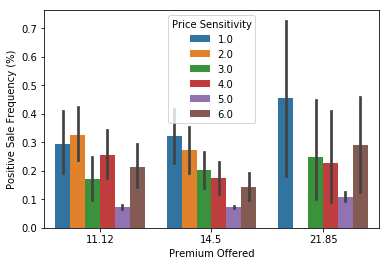

In [21]:
g = sns.barplot(y ='Sales', x='Premium Offered',hue='Price Sensitivity',data=db_20k_imp_nd)
_ = g.set(xlabel='Premium Offered', ylabel='Positive Sale Frequency (%)')

For the two lower premiums, there is a more or less clear decreasing pattern, which means people with higher price sensitivity are less likely to buy, which makes sense.

In the case of the highest premium, people with the lowest price sensitivity are more likely to buy, then the pattern is not so clear (besides, the number of samples is quite small for this group, leading to very wide confidence intervals, that is, a lot of variability).

It also important to consider that 'Price Sensitivity' lacked more than 90% of its values, and the imputation process replaced most of them with the value 5, hence the narrow CIs for this subgroup and the uniformity of its Sale Frequency values.

C:\Users\amartinp\AppData\Local\conda\conda\envs\ml_env\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


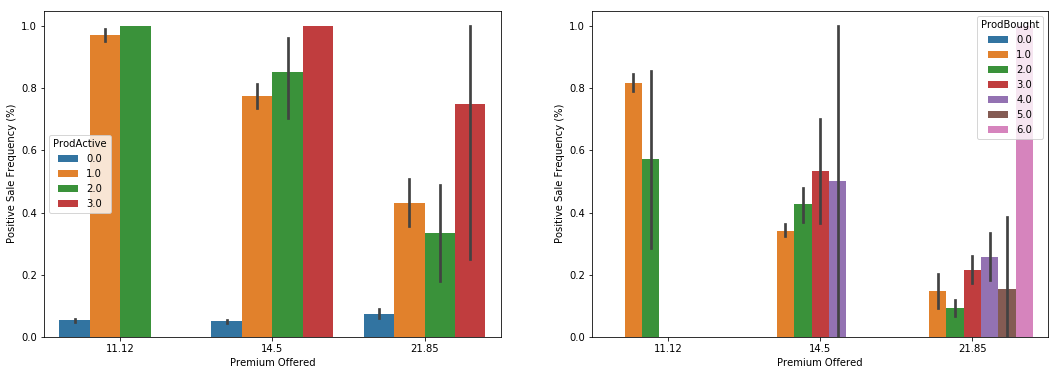

In [22]:
fig, axs = plt.subplots(1, 2, figsize=(18, 6), gridspec_kw = dict(wspace = 0.2), sharey=False)
g1 = sns.barplot(y ='Sales', x='Premium Offered',hue='ProdActive',data=db_20k_imp_nd, ax=axs[0])
_ = g1.set(xlabel='Premium Offered', ylabel='Positive Sale Frequency (%)')
g2 = sns.barplot(y ='Sales', x='Premium Offered',hue='ProdBought',data=db_20k_imp_nd, ax=axs[1])
_ = g2.set(xlabel='Premium Offered', ylabel='Positive Sale Frequency (%)')

In the plot on the left we can see the great influence of number of active products a client have. In some cases, all clients who have a given number of active products have bought an insurance.

For all values of 'Premium Offered', those clients who have no products active have a very low chance of buying, according to this data. The conclusion from this is twofold: clients who have no active products (most of them) should be studied in order to find incentives that would make them buy, and clients who already have a product are already prone to buy, so they should be approached from time to time to attempt a cross-sale or an up-sale.

In the plot on the right the patterns are not so clear, but for the two higher premiums, we see some increase in positive sale probability as the number of previously bought products goes up. We can also see that the two higher premiums are mainly bought for those people who have already bought several products, as opposed to the lowest one, whose buyers have bought only one or sometimes two products before.

***

### 3.2 Continuous features

They all represent quantitative aspects of the economic or living conditions of the clients.

We will first look at their individual distributions (KDEs, across the diagonal of the pairplot) and pairwise joint distributions (scatter plots).

In [23]:
cont_ft = ['Living Area (m^2)','House Price','Income','House Insurance','Pension Plan','Credit','Savings']

C:\Users\amartinp\AppData\Local\conda\conda\envs\ml_env\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


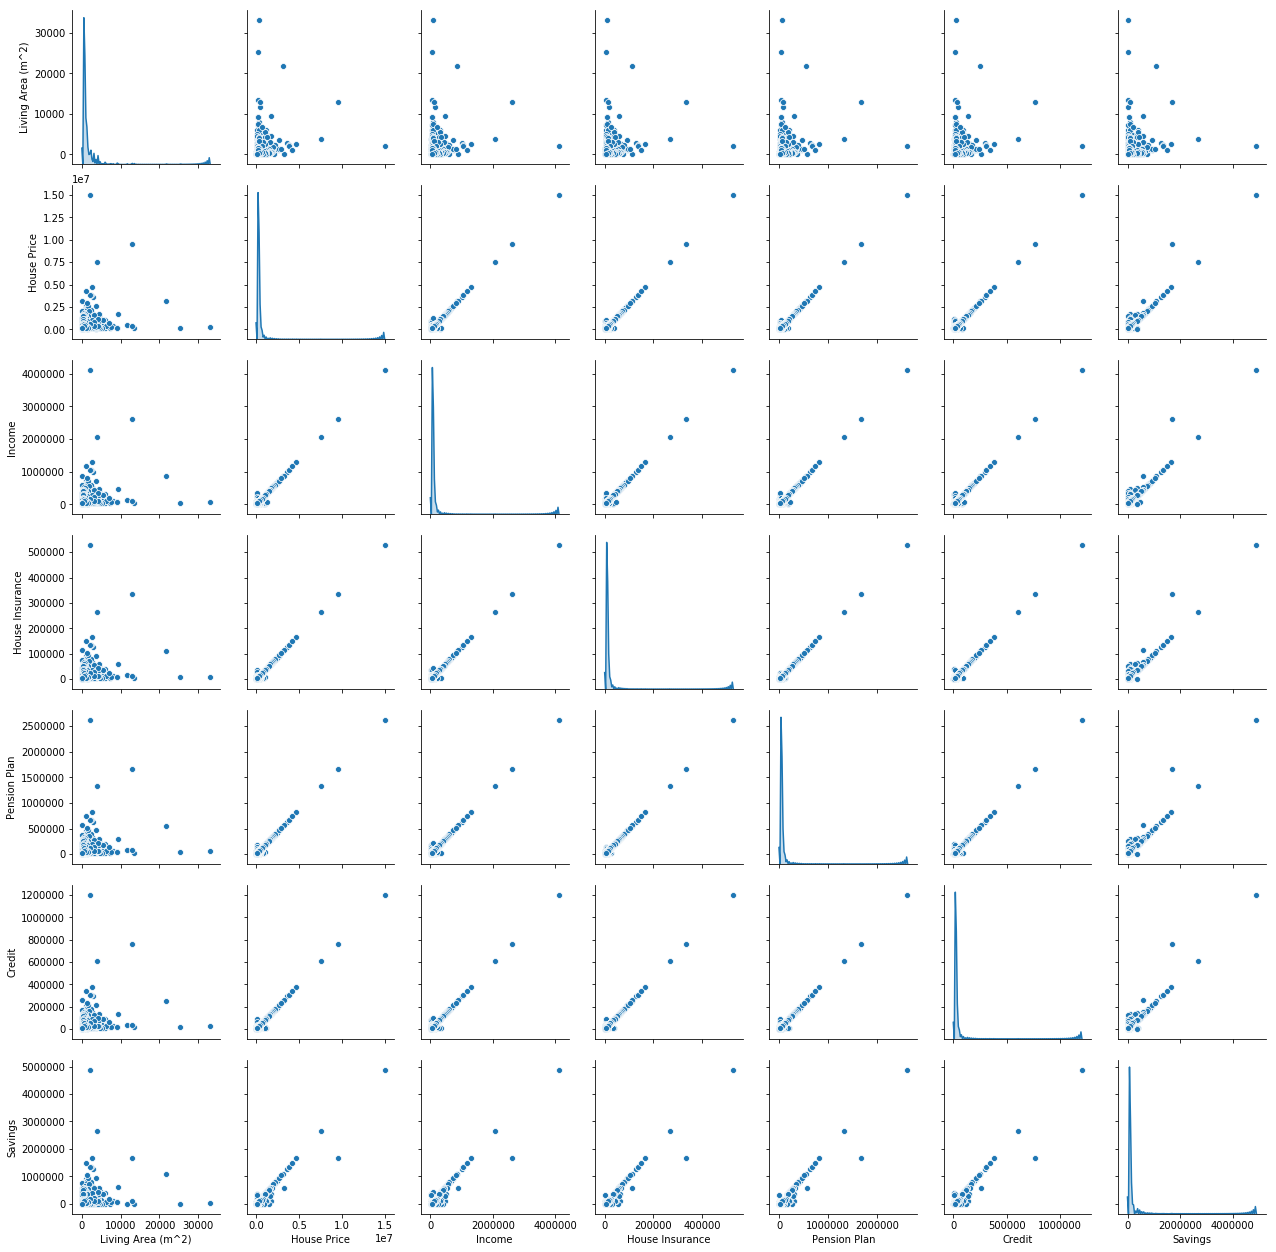

In [24]:
_ = sns.pairplot(db_20k_imp_nd,vars=cont_ft,diag_kind = 'kde')

Regarding their individual distributions, they are all considerably skewed towards the lower values. Wealth distribution in most populations follows this pattern, so this is perfectly normal.

In this dataset, there is a fair amount of individuals whose economical and living conditions are well above the average, with a few ones that stand out even more (incomes, savings, and house prices over 1 million monetary units). Statistically speaking, they can be considered outliers, but they are probably not anomalous data.

It also obvious that there is a very strong linear relationship between all of them but 'Living Area', which makes since they speak of economic status.

In any case, the great skewness produced by the very different scales between individuals make the 'lower values' region relatively overpopulated, which makes the scatter plots difficult to read.

In order to make things clear, we will take the logarithms of these 7 variables and rebuild the plot.

C:\Users\amartinp\AppData\Local\conda\conda\envs\ml_env\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


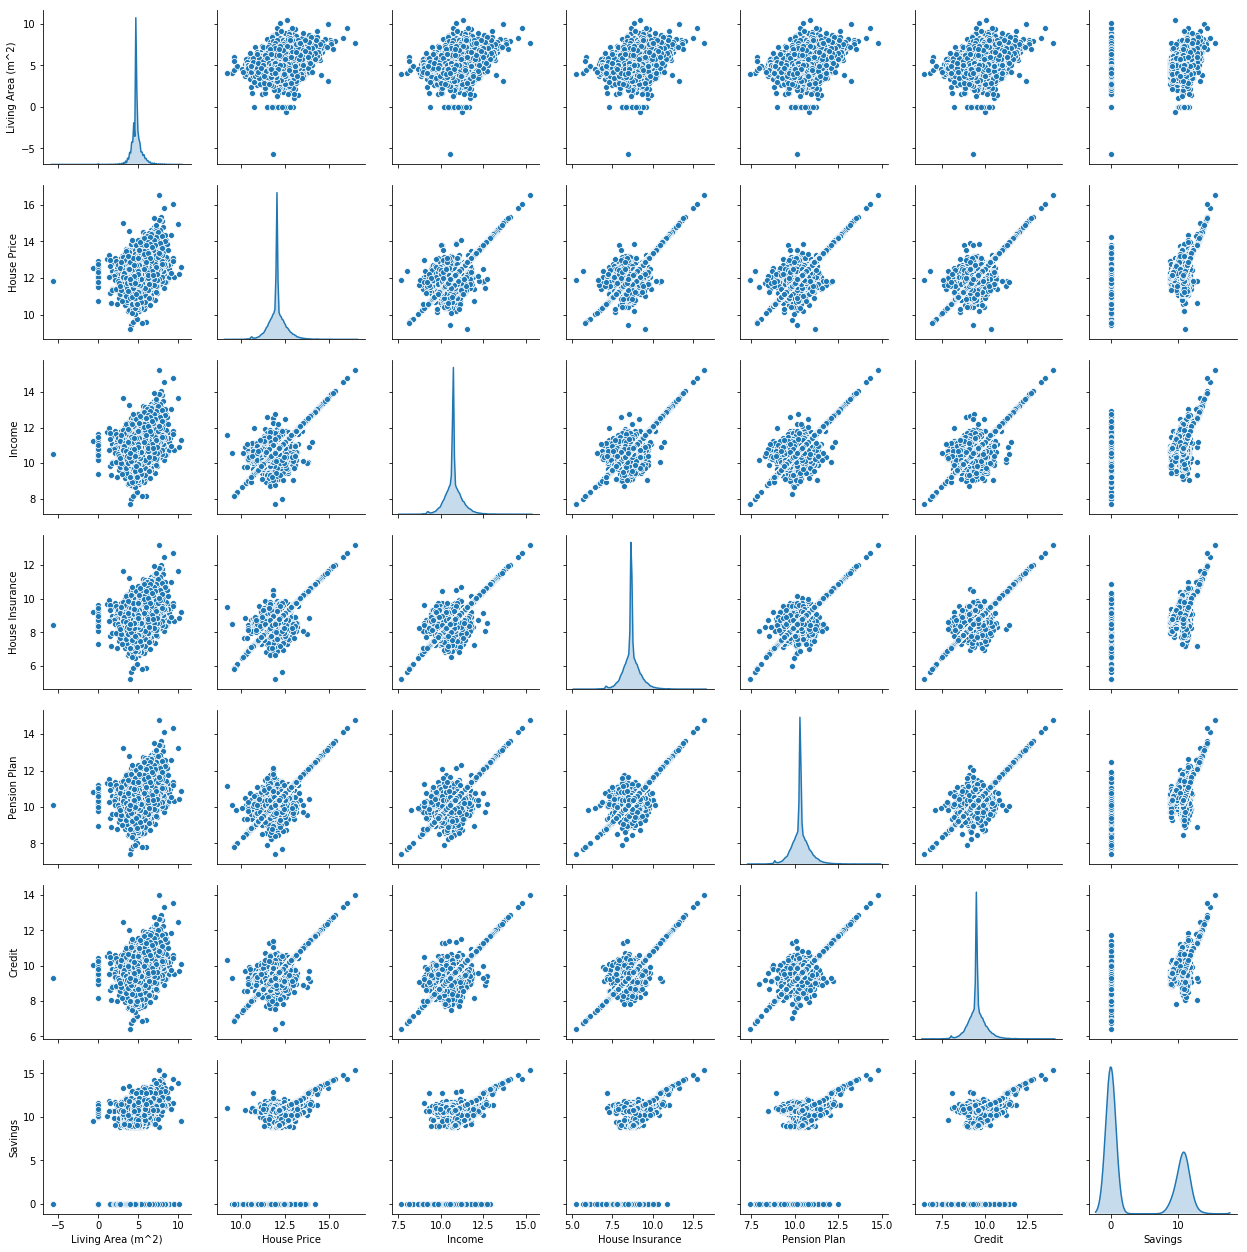

In [25]:
db_20k_imp_nd_log = db_20k_imp_nd.copy()
for column in cont_ft:
    db_20k_imp_nd_log[column] = db_20k_imp_nd[column].apply(lambda x: np.log(x) if x > 0 else 0)
    
_ = sns.pairplot(db_20k_imp_nd_log,vars=cont_ft,diag_kind = 'kde')

Now this provides a much clearer view of the distributions. 

The individual distributions get more centered, and more or less symmetric (except for 'Savings' which presents 2 peaks due to the fact that there are many individuals with no savings at all). We will not say they look normally distributed since their kurtosis looks quite high, though.

Looking at the pair-wise joint distributions, the data points which were completely clumped at the left bottom corners still look like clump, only more scattered. This clumps represent the majority of average economic level individuals, where there is a lot of variability and not a clear relationship between the different economic features.

On top of them, we see a notaworthy amount of perfectly aligned data points. Their correlation is so perfect that it makes us think that they are probably synthetic data added to the dataset on purpose.

We will analyse the relationship between all these features and our target variable 'Sales', by means of violin plots.

C:\Users\amartinp\AppData\Local\conda\conda\envs\ml_env\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


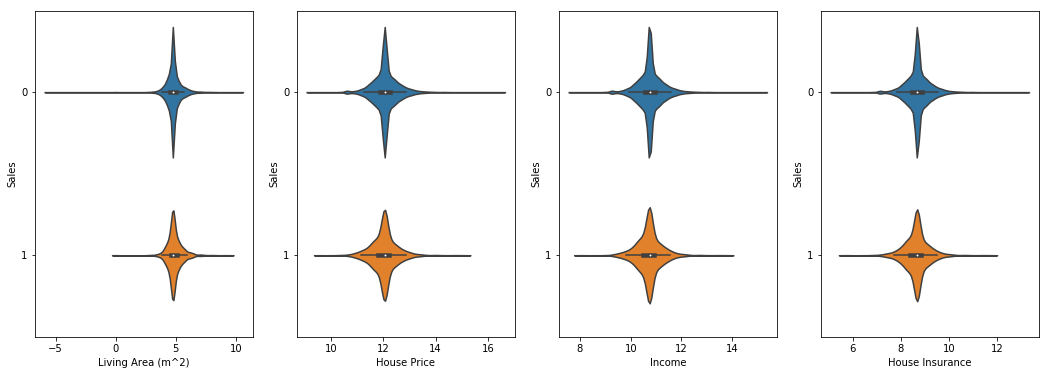

In [26]:
fig, axs = plt.subplots(1, 4, figsize=(18, 6), gridspec_kw = dict(wspace = 0.2))
_ = sns.violinplot(x='Living Area (m^2)', y='Sales', hue=None, data=db_20k_imp_nd_log, orient='h',ax=axs[0])
_ = sns.violinplot(x='House Price', y='Sales', hue=None, data=db_20k_imp_nd_log, orient='h',ax=axs[1])
_ = sns.violinplot(x='Income', y='Sales', hue=None, data=db_20k_imp_nd_log, orient='h',ax=axs[2])
_ = sns.violinplot(x='House Insurance', y='Sales', hue=None, data=db_20k_imp_nd_log, orient='h',ax=axs[3])

C:\Users\amartinp\AppData\Local\conda\conda\envs\ml_env\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


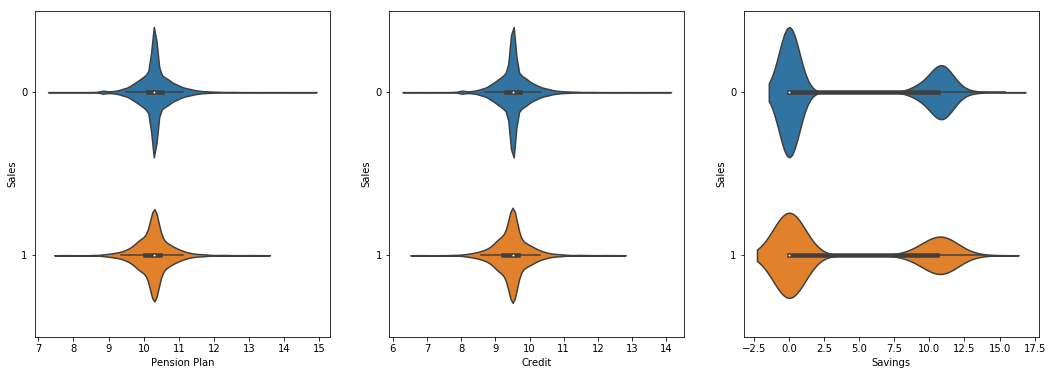

In [27]:
fig, axs = plt.subplots(1, 3, figsize=(18, 6), gridspec_kw = dict(wspace = 0.2))
_ = sns.violinplot(x='Pension Plan', y='Sales', hue=None, data=db_20k_imp_nd_log, orient='h',ax=axs[0])
_ = sns.violinplot(x='Credit', y='Sales', hue=None, data=db_20k_imp_nd_log, orient='h',ax=axs[1])
_ = sns.violinplot(x='Savings', y='Sales', hue=None, data=db_20k_imp_nd_log, orient='h',ax=axs[2])

For all seven features, we see that they present almost identical distributions for 'Sales' = 0 and 'Sales' = 1. This means the probability of positive Sale does not clearly depend on this economic variables (separately).

***

### 3.3 Discrete features

Here we can distinguish between features that represent dates ('Tenure' and 'yearBuilt', since 'Birthdate' was dropped out), which present a moderate amount of distinct values from those that represent pure categories (ordinal or not), which present very few distinct values.

#### Dates

C:\Users\amartinp\AppData\Local\conda\conda\envs\ml_env\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


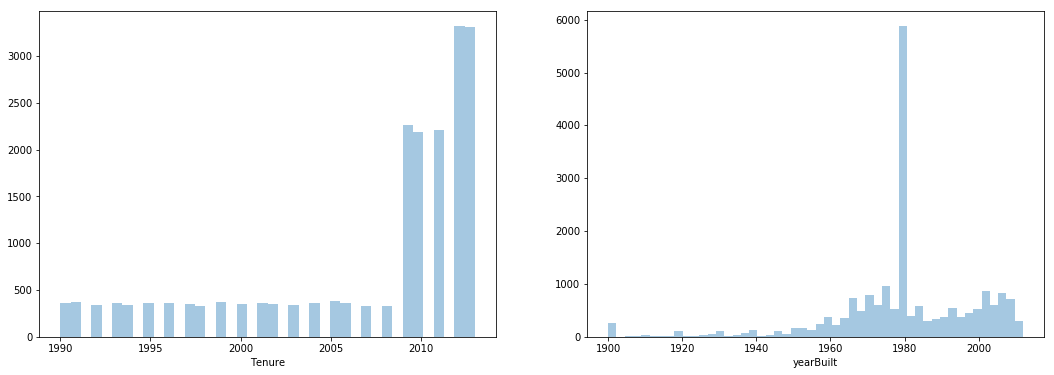

In [28]:
fig, axs = plt.subplots(1, 2, figsize=(18, 6), gridspec_kw = dict(wspace = 0.2))
_ = sns.distplot(db_20k_imp_nd['Tenure'],kde=False,ax=axs[0])
_ = sns.distplot(db_20k_imp_nd['yearBuilt'],kde=False,ax=axs[1])

'Tenure', that is, the year an individual became a client, is more or less uniformly distributed from 1990 to 2008. From that point onwards, there are many more clients. The fact that most samples in this dataset correspond to recently adquired clients might be relevant with respect to sales prospects.

'yearBuilt' presents an irregular distribution which is denser on the right side (more recently built houses) plus a great peak that comes from the imputation process once again.

C:\Users\amartinp\AppData\Local\conda\conda\envs\ml_env\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


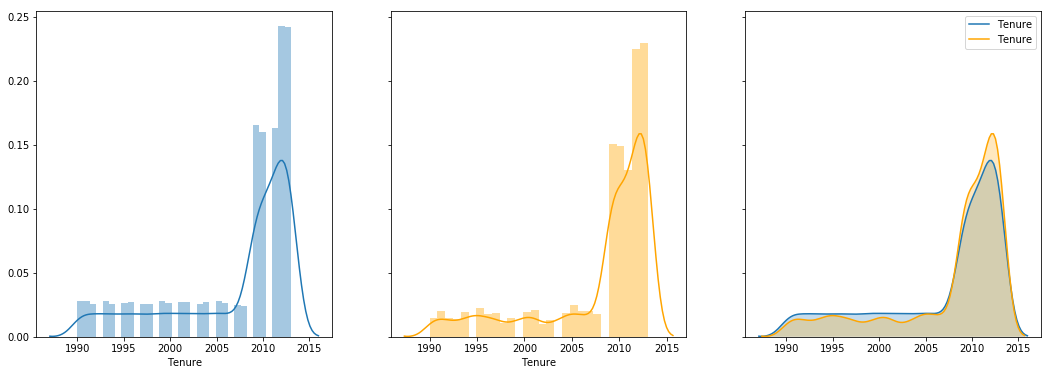

In [29]:
fig, axs = plt.subplots(1, 3, figsize=(18, 6), gridspec_kw = dict(wspace = 0.2), sharey=True)
_ = sns.distplot(db_20k_imp_nd.loc[db_20k_imp_nd['Sales'] == 0,'Tenure'],ax=axs[0])
_ = sns.distplot(db_20k_imp_nd.loc[db_20k_imp_nd['Sales'] == 1,'Tenure'],ax=axs[1],color='orange')
_ = sns.kdeplot(db_20k_imp_nd.loc[db_20k_imp_nd['Sales'] == 0,'Tenure'],shade=True,ax=axs[2])
_ = sns.kdeplot(db_20k_imp_nd.loc[db_20k_imp_nd['Sales'] == 1,'Tenure'],shade=True,ax=axs[2],color='orange')

The distribution of 'Tenure' values corresponding to positive sales looks very similar to the distribution of 'Tenure' values corresponding to negative sales. They both peak at more recent dates, being more or less uniform for earlier ones.

Overall this means that positive sale probability is not too affected by 'Tenure' on its own.

C:\Users\amartinp\AppData\Local\conda\conda\envs\ml_env\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


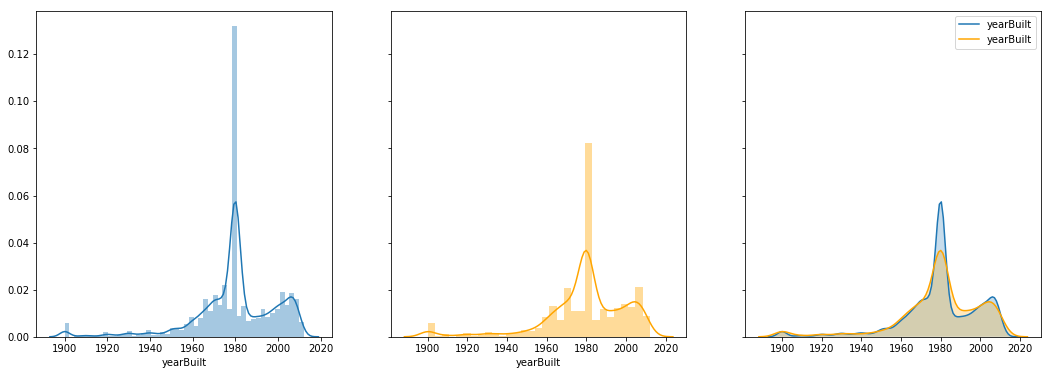

In [30]:
fig, axs = plt.subplots(1, 3, figsize=(18, 6), gridspec_kw = dict(wspace = 0.2), sharey=True)
_ = sns.distplot(db_20k_imp_nd.loc[db_20k_imp_nd['Sales'] == 0,'yearBuilt'],ax=axs[0])
_ = sns.distplot(db_20k_imp_nd.loc[db_20k_imp_nd['Sales'] == 1,'yearBuilt'],ax=axs[1],color='orange')
_ = sns.kdeplot(db_20k_imp_nd.loc[db_20k_imp_nd['Sales'] == 0,'yearBuilt'],shade=True,ax=axs[2])
_ = sns.kdeplot(db_20k_imp_nd.loc[db_20k_imp_nd['Sales'] == 1,'yearBuilt'],shade=True,ax=axs[2],color='orange')

We have a similar situation for 'yearBuilt', where value distribution for both positive and negative sales are pretty similar.

***

#### Ordirnal Features

C:\Users\amartinp\AppData\Local\conda\conda\envs\ml_env\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


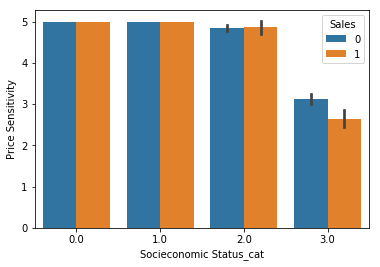

In [31]:
_ = sns.barplot(y ='Price Sensitivity', x='Socieconomic Status_cat',hue='Sales',data=db_20k_imp_nd)

We first check the distribution of values across Socieconomic Statuses, to see that our imputation custom model did not impact the original distribution fot the two highest statuses, and that filled the others with a Price Sensitivity of 5 (as expected).

C:\Users\amartinp\AppData\Local\conda\conda\envs\ml_env\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


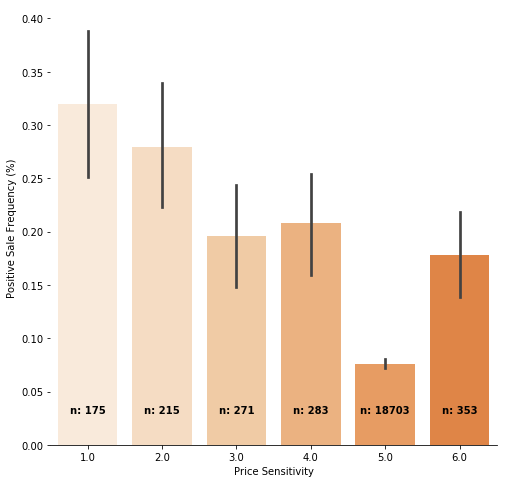

In [32]:
_ = barplot_cstm(x="Price Sensitivity",y="Sales",data=db_20k_imp_nd,
                 xlabel='Price Sensitivity',ylabel='Positive Sale Frequency (%)')

If we look at the Price Sensitivity and the associated frequency of positive sales, we can actually see a pattern, where individuals with lower sensitivity are more prone to buy.

We can also see that most of the imputed values corresponded to lower Socieconomic Statuses and higher Price Sensitivities (5) given the large number of samples for this value.

C:\Users\amartinp\AppData\Local\conda\conda\envs\ml_env\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


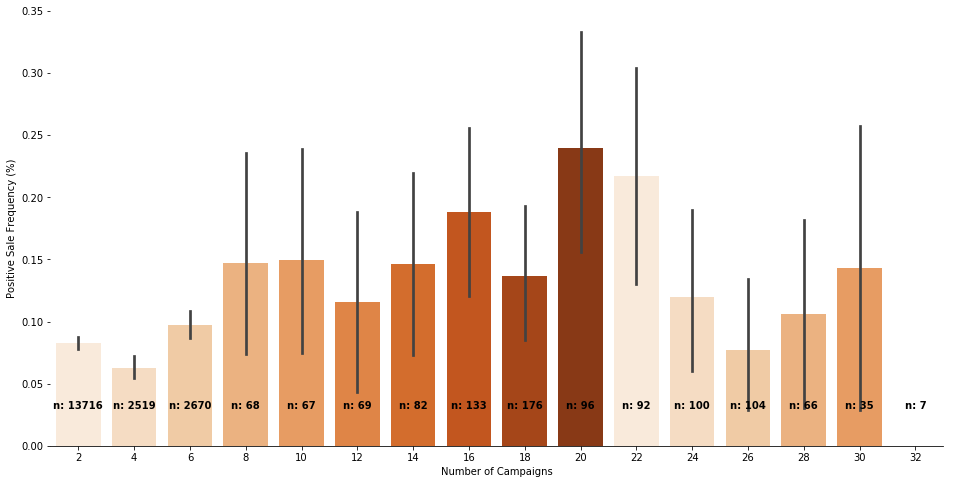

In [33]:
_ = barplot_cstm(x="NumberofCampaigns",y="Sales",data=db_20k_fs,
                 xlabel='Number of Campaigns',ylabel='Positive Sale Frequency (%)',figsize=(16,8))

More than 65% of the clients have been called twice, and that about 25% have been called 4 or 6 times, and they all have low frequency of positive sales.

The remaining 10% have been called 8 times or more (up to 32 times). They present higher positive sale frequencies in a not very clear pattern: highest frequencies are around 16 and 22 contact calls, but the number of samples are not that high and the conficende intervals quite wide.

We could say it is effective to insist with the calls to a certain point, but that does no guarantee success, and the cost of such calls needs to be considered in order to correctly assess the profitability of the campaign.

C:\Users\amartinp\AppData\Local\conda\conda\envs\ml_env\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


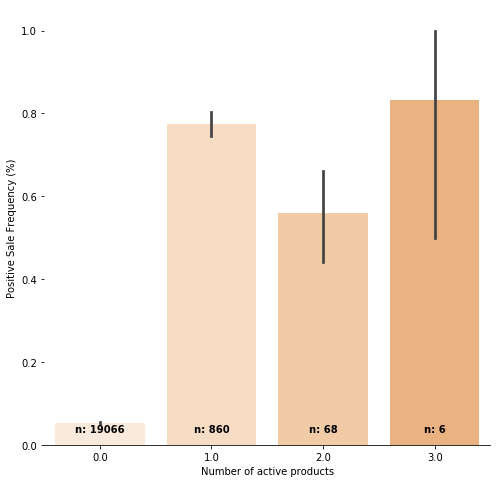

In [34]:
_ = barplot_cstm(x="ProdActive",y="Sales",data=db_20k_imp_nd,
                 xlabel='Number of active products',ylabel='Positive Sale Frequency (%)')

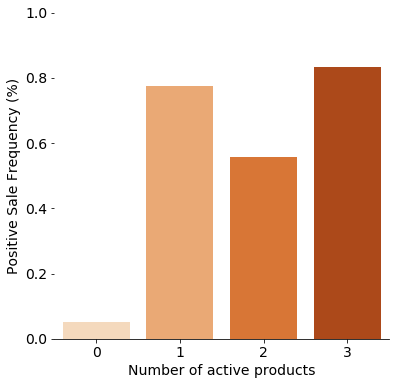

In [35]:
# Figure for ppt
fig, ax = plt.subplots(figsize=(6,6))
sns.barplot(x ='ProdActive',y='Sales',data=db_20k_imp_nd,
            ax=ax,palette=sns.color_palette("Oranges", 4),ci=None)

ax.set_xlabel('Number of active products', fontsize=14)
ax.set_ylabel('Positive Sale Frequency (%)', fontsize=14)
ax.xaxis.set_tick_params(labelsize=14)
ax.yaxis.set_tick_params(labelsize=14)
ax.set_ylim(0,1)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)

ft_labels = ['0','1','2','3']
_ = plt.xticks(np.arange(len(ft_labels)),ft_labels)

fig.savefig("sales_by_prodactive.svg", bbox_inches='tight')

The number of active products has a really strong influence on the frequency of positive sales. If we look at the number of samples per column, we see about 5% of them correspond to a non null number of active products.

Conclusion: People who currently have at least one product are more likely to buy another one than those who do not.

C:\Users\amartinp\AppData\Local\conda\conda\envs\ml_env\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


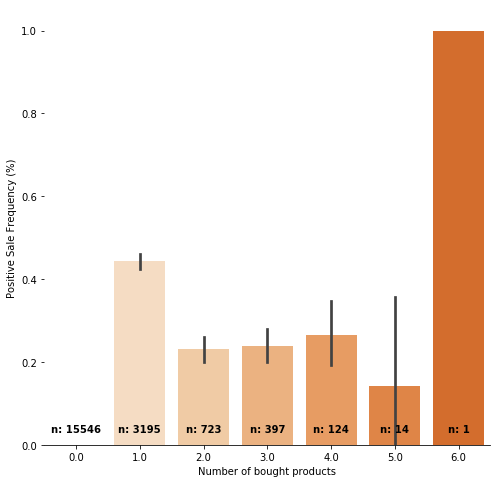

In [36]:
_ = barplot_cstm(x="ProdBought",y="Sales",data=db_20k_imp_nd,
                 xlabel='Number of bought products',ylabel='Positive Sale Frequency (%)')

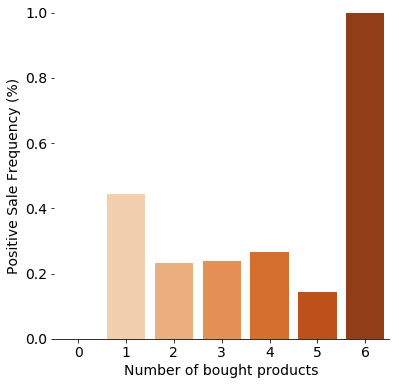

In [37]:
# Figure for ppt
fig, ax = plt.subplots(figsize=(6,6))
sns.barplot(x ='ProdBought',y='Sales',data=db_20k_imp_nd,
            ax=ax,palette=sns.color_palette("Oranges", 7),ci=None)

ax.set_xlabel('Number of bought products', fontsize=14)
ax.set_ylabel('Positive Sale Frequency (%)', fontsize=14)
ax.xaxis.set_tick_params(labelsize=14)
ax.yaxis.set_tick_params(labelsize=14)
ax.set_ylim(0,1)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)

ft_labels = ['0','1','2','3','4','5','6']
_ = plt.xticks(np.arange(len(ft_labels)),ft_labels)

fig.savefig("sales_by_prodbought.svg", bbox_inches='tight')

We have a similar scenario with the number of products previously bought by clients. Those who have not bought a product so far are not likely to respond positively to future sales (according to this dataset, none of these clients, about 75%, have responded positively).

For those who have already bought a product before the positive sale frequency varies between 14% and 42%* (approx.), the higher value corresponding to those who have bought just one product before (about 15% of all the clients in the dataset).

*Ignoring the one person who already had 6 products and bought another one.

C:\Users\amartinp\AppData\Local\conda\conda\envs\ml_env\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


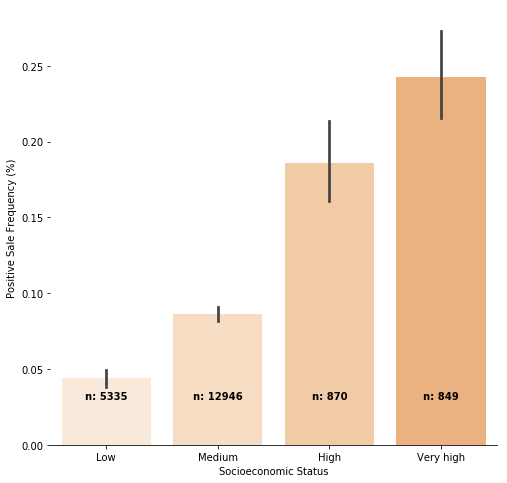

In [38]:
_ = barplot_cstm(x="Socieconomic Status_cat",y="Sales",data=db_20k_imp_nd,
                 xlabel='Socioeconomic Status',ylabel='Positive Sale Frequency (%)')

bars = ['Low','Medium','High','Very high']
_ = plt.xticks(np.arange(len(bars)),bars)

People with higher socioeconomic status are more prone to buy an insurance product.

C:\Users\amartinp\AppData\Local\conda\conda\envs\ml_env\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


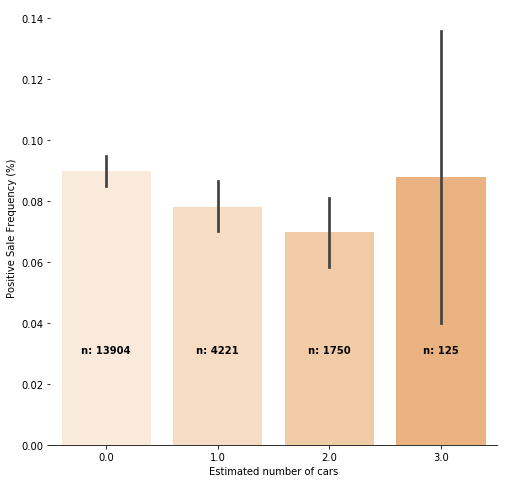

In [39]:
_ = barplot_cstm(x="Estim. num. cars_cat",y="Sales",data=db_20k_imp_nd,
                 xlabel='Estimated number of cars',ylabel='Positive Sale Frequency (%)')

The estimated number of cars does not show any pattern with respect to the positive sale frequency.

C:\Users\amartinp\AppData\Local\conda\conda\envs\ml_env\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


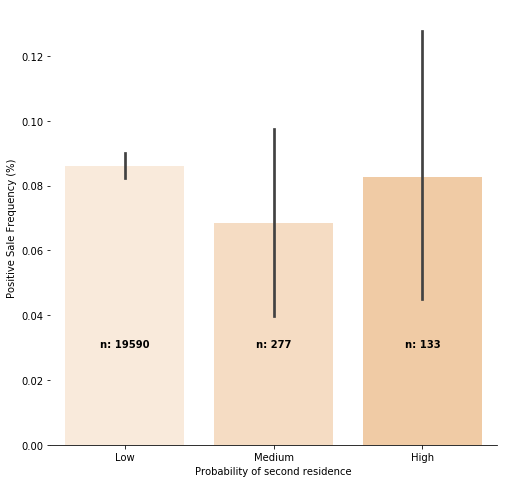

In [40]:
_ = barplot_cstm(x="Proba. Sec. Res._cat",y="Sales",data=db_20k_imp_nd,
                 xlabel='Probability of second residence',ylabel='Positive Sale Frequency (%)')

bars = ['Low','Medium','High']
_ = plt.xticks(np.arange(len(bars)),bars)

Similarly to the estimated number of cars, the probability of a second residence does not say a lot about the prospect of a future sale by itself.

***

#### Pure categorical features

In [41]:
db_20k_imp_nd.columns

Index(['Price Sensitivity', 'Email', 'Tenure', 'NumberofCampaigns',
       'ProdActive', 'ProdBought', 'Living Area (m^2)', 'House Price',
       'Income', 'yearBuilt', 'House Insurance', 'Pension Plan', 'Credit',
       'Savings', 'PhoneType_cat', 'Province_cat', 'Right Address_cat',
       'Type of House_cat', 'Socieconomic Status_cat', 'Estim. num. cars_cat',
       'Proba. Sec. Res._cat', 'Sales', 'Premium Offered'],
      dtype='object')

C:\Users\amartinp\AppData\Local\conda\conda\envs\ml_env\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


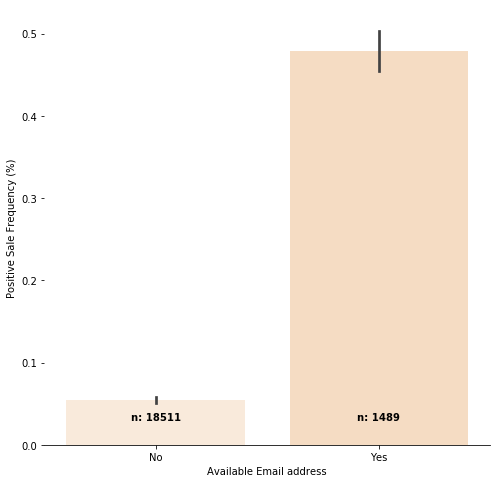

In [42]:
_ = barplot_cstm(x="Email",y="Sales",data=db_20k_imp_nd,
                 xlabel='Available Email address',ylabel='Positive Sale Frequency (%)')

bars = ['No','Yes']
_ = plt.xticks(np.arange(len(bars)),bars)

The pattern here is quite noteworthy: those people whose email address is available are much more likely to contract a product than those whose email is not available.

Besides, about 93 % of clients' emails are not available. If email is the preferred communication channel of these people, this  is something the insuranca company should try to improve.

C:\Users\amartinp\AppData\Local\conda\conda\envs\ml_env\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


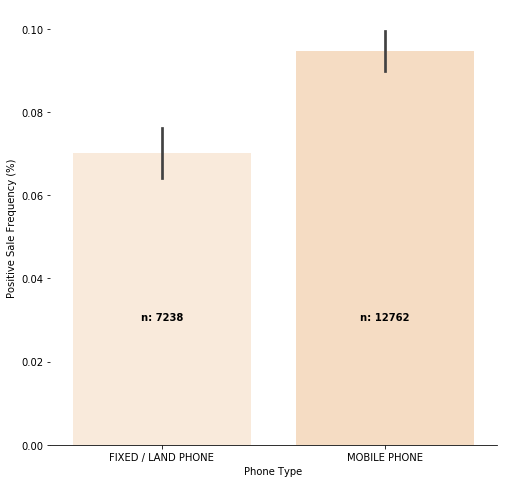

In [43]:
_ = barplot_cstm(x="PhoneType_cat",y="Sales",data=db_20k_imp_nd,
                 xlabel='Phone Type',ylabel='Positive Sale Frequency (%)')
bars = ['FIXED / LAND PHONE','MOBILE PHONE']
_ = plt.xticks(np.arange(len(bars)),bars)

More clients provide a mobile phone number to our insurance company for contact, and they have a slightly higher frequency of positive sales than those who provide a land phone number. In any case, there is not a big imbalance between the number of individuals or their positive sale frequency in both categories, which means this feature is not very informative by itself.

C:\Users\amartinp\AppData\Local\conda\conda\envs\ml_env\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


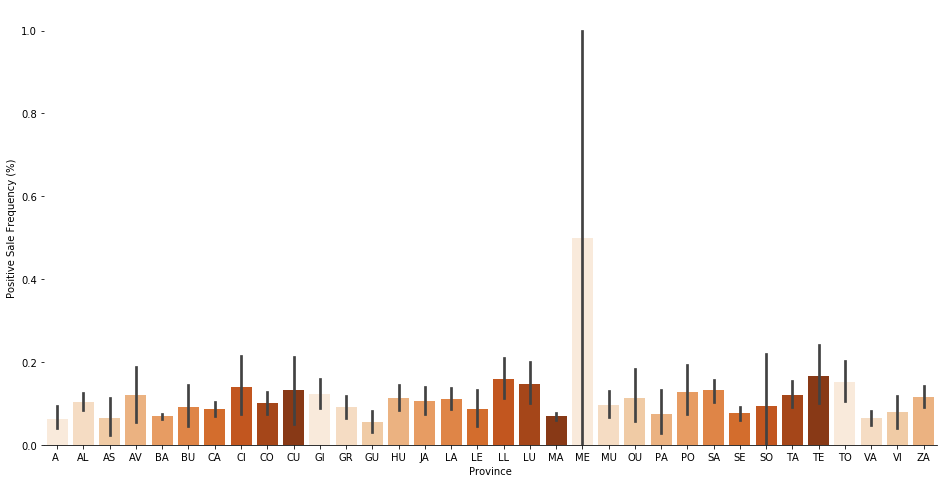

In [44]:
_ = barplot_cstm(x="Province_cat",y="Sales",data=db_20k_imp_nd,
                 xlabel='Province',ylabel='Positive Sale Frequency (%)',
                 figsize=(16,8),n_samples=False)
bars = ['A ', 'AL', 'AS', 'AV', 'BA', 'BU', 'CA', 'CI', 'CO', 'CU',
        'GI', 'GR', 'GU', 'HU', 'JA', 'LA', 'LE', 'LL', 'LU', 'MA',
        'ME', 'MU', 'OU', 'PA', 'PO', 'SA', 'SE', 'SO', 'TA', 'TE',
        'TO', 'VA', 'VI', 'ZA']
_ = plt.xticks(np.arange(len(bars)),bars)

There are provinces where the posite sale frequency is higher (even though there is an important level of variance for many of them). Overall the relationship with our target variable is not so clear.

This kind of data would be useful if some kind of regional segmentation was to be performed before defining the targets of the next sale campaign.

C:\Users\amartinp\AppData\Local\conda\conda\envs\ml_env\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


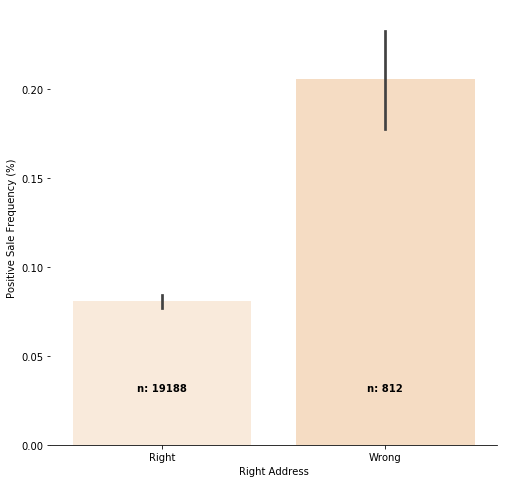

In [45]:
_ = barplot_cstm(x="Right Address_cat",y="Sales",data=db_20k_imp_nd
                 ,xlabel='Right Address',ylabel='Positive Sale Frequency (%)')

bars = ['Right','Wrong']
_ = plt.xticks(np.arange(len(bars)),bars)

Those clients whose address is wrong have more than double the frequency of positive sale than those whose address is correct.

No definitive conclusions should be drawn out of this since less than 5% of the clients have a wrong address.

C:\Users\amartinp\AppData\Local\conda\conda\envs\ml_env\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


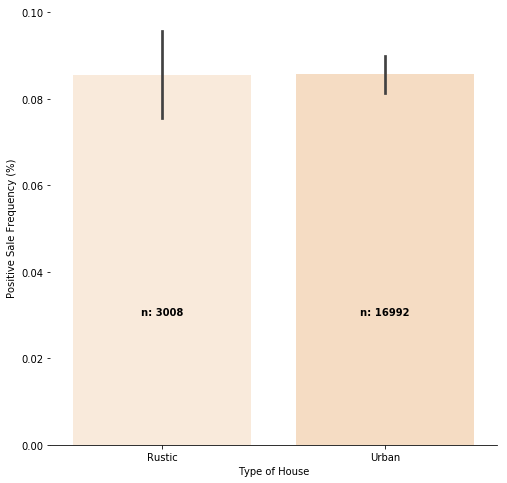

In [46]:
_ = barplot_cstm(x="Type of House_cat",y="Sales",data=db_20k_imp_nd
                 ,xlabel='Type of House',ylabel='Positive Sale Frequency (%)')

bars = ['Rustic','Urban']
_ = plt.xticks(np.arange(len(bars)),bars)

Many more clients have a house in an urban area than in a rustic one. It makes no difference by itself with respect to sales.